In [1]:
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pickle
import matplotlib
import pandas as pd
import Sampler
import h5py
from astropy.table import Table
from astroquery.gaia import Gaia

/home/bepennell/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [3]:
main_table = Table.read('./data/200pc_mdwarfs_reduced.fits', format='fits')
orbit_solutions = main_table[main_table["solution_type"] == 12]

In [4]:
import os
os.environ["XDG_CACHE_HOME"] = os.path.expanduser("~/.astroquery_tmp")

In [5]:
ids = orbit_solutions["source_id"]
ids_str = ",".join(str(sid) for sid in ids)
query = f"""
SELECT *
FROM gaiadr3.nss_two_body_orbit
WHERE source_id IN ({ids_str})
"""
job = Gaia.launch_job(query, verbose=False)
results = job.get_results()

In [6]:
results.remove_column("corr_vec")

In [19]:
es = np.linspace(np.min(results["eccentricity"]), np.max(results["eccentricity"]), 1000)
pes = Sampler.gaussian(es, 0.38, 0.2)
pes = pes / np.trapz(pes, es)

/tmp/ipykernel_1194300/3580663457.py:3: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  pes = pes / np.trapz(pes, es)


In [20]:
pts = Sampler.pexp(es, 1)   
pts = pts / np.trapz(pts, es)

/tmp/ipykernel_1194300/2706430422.py:2: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  pts = pts / np.trapz(pts, es)


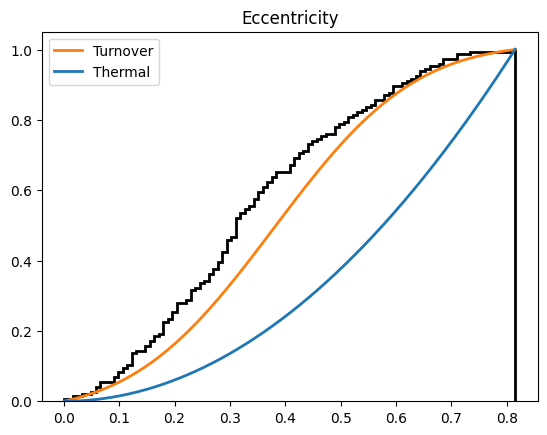

In [ ]:
plt.hist(results["eccentricity"], bins=100, histtype="step", cumulative=True, density=True, linewidth=2, color="k");
plt.plot(es, np.cumsum(pes) * (es[1] - es[0]), color="C1", linewidth=2, label="Gaussian");
plt.plot(es, np.cumsum(pts) * (es[1] - es[0]), color="C0", linewidth=2, label="Thermal");
plt.title("Eccentricity");
plt.legend();

In [124]:
ps = np.linspace(2,3, 1000)
pps = Sampler.gaussian(ps, 4, 1.3)
pps = pps / np.trapz(pps, ps)

/tmp/ipykernel_1194300/225206198.py:3: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  pps = pps / np.trapz(pps, ps)


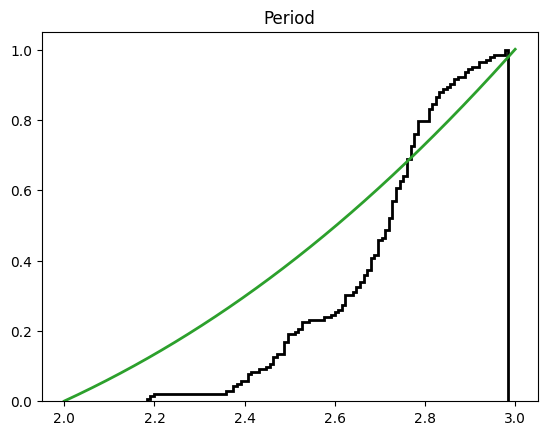

In [153]:
periods = np.log10(results["period"])
plt.hist(periods[(periods > 2) & (periods < 3)], bins=100, histtype="step", cumulative=True, density=True, linewidth=2, color="k");
plt.plot(ps, np.cumsum(pps) * (ps[1] - ps[0]), color="C2", linewidth=2);
plt.title("Period");

In [8]:
import utils.compute_fm as fm

In [9]:
labels = ["period", "eccentricity", "m2", "t_periastron"]
for label in labels:
    try:
        orbit_solutions.add_column(np.zeros(len(orbit_solutions)), name=label)
    except:
        pass

In [10]:
for row in orbit_solutions:
    result_row = results[results["source_id"] == row["source_id"]]
    row["m2"] = fm.companion_mass(row["mass_single"], fm.mass_function(result_row[0]))
    row["period"] = result_row["period"][0]
    row["eccentricity"] = result_row["eccentricity"][0]
    row["t_periastron"] = result_row["t_periastron"][0] / result_row["period"][0]

/home/bepennell/research/BrownDwarfProbabilities/utils/compute_fm.py:8: UserWarning: Warning: converting a masked element to nan.
  A,B,C,F,G,H = float(A), float(B), float(C), float(F), float(G), float(H)


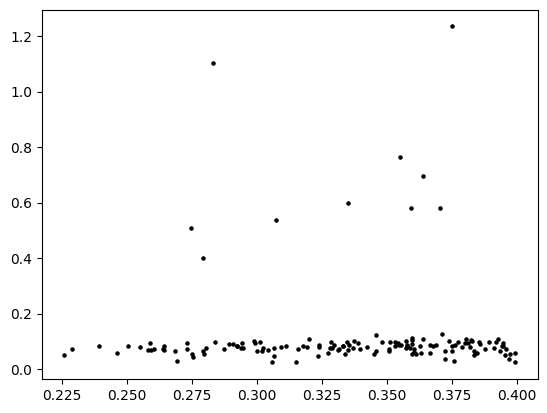

In [15]:
plt.scatter(orbit_solutions["mass_single"], orbit_solutions["m2"], color="k", s=5);

/tmp/ipykernel_1194300/867598191.py:5: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  qps = qps / np.trapz(qps, qs)


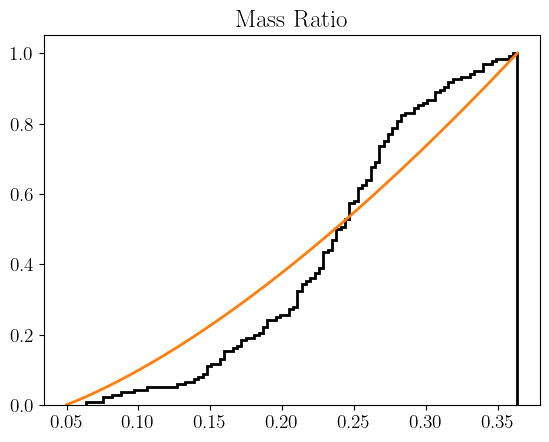

In [175]:
reasonable_mask = (orbit_solutions["m2"]/orbit_solutions["mass_single"]) < 1.0
mass_ratios = (orbit_solutions["m2"]/orbit_solutions["mass_single"])[reasonable_mask]
qs = np.linspace(0.05, np.max(mass_ratios), 1000)
qps = Sampler.pexp(qs, 0.5)
qps = qps / np.trapz(qps, qs)
plt.hist(mass_ratios, bins=100, histtype="step", cumulative=True, density=True, linewidth=2, color="k");
plt.plot(qs, np.cumsum(qps) * (qs[1] - qs[0]), color="C1", linewidth=2);
plt.title("Mass Ratio");

In [154]:
import style

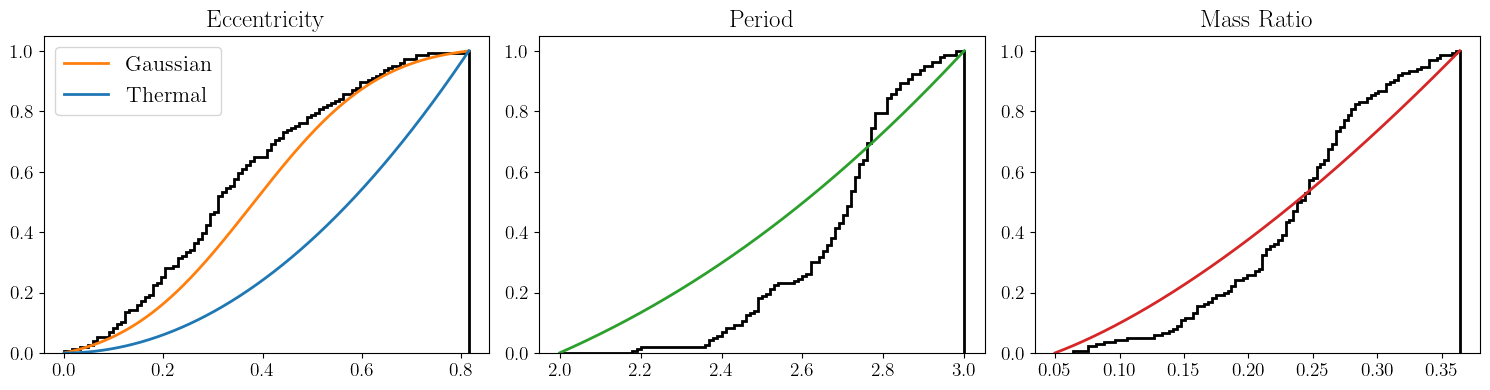

In [177]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Eccentricity
axes[0].hist(results["eccentricity"], bins=100, histtype="step", cumulative=True, density=True, linewidth=2, color="k")
axes[0].plot(es, np.cumsum(pes) * (es[1] - es[0]), color="C1", linewidth=2, label="Gaussian");
axes[0].plot(es, np.cumsum(pts) * (es[1] - es[0]), color="C0", linewidth=2, label="Thermal");
axes[0].set_title("Eccentricity");
axes[0].legend();

# Period
axes[1].hist(np.log10(results["period"]), bins=100, histtype="step", cumulative=True, density=True, linewidth=2, color="k", range=(2,3))
axes[1].plot(ps, np.cumsum(pps) * (ps[1] - ps[0]), color="C2", linewidth=2)
axes[1].set_title("Period")

# Mass Ratio
axes[2].hist(mass_ratios, bins=100, histtype="step", cumulative=True, density=True, linewidth=2, color="k")
axes[2].plot(qs, np.cumsum(qps) * (qs[1] - qs[0]), color="C3", linewidth=2)
axes[2].set_title("Mass Ratio")

plt.tight_layout()

## etc

In [11]:
import sys
import os
folder_a_path = os.path.abspath(os.path.join(os.getcwd(), '../BHPopulation'))
if folder_a_path not in sys.path:
    sys.path.append(folder_a_path)
    
import GaiamockWrapper as gw

In [13]:
rates = []
for i in tqdm(range(len(orbit_solutions))):
    m1 = orbit_solutions["mass_single"][i]
    solrate = gw.marginalize_solution_type(sample_count=100, only_full=True, diagnose=False, m1=m1, q=orbit_solutions["m2"][i]/m1, f=1e-10, 
                                parallax=orbit_solutions["parallax"][i], phot_g_mean_mag=orbit_solutions["phot_g_mean_mag"][i],
                                period=orbit_solutions["period"][i], ecc=orbit_solutions["eccentricity"][i],
                                catalogue=main_table, marginalize_angles=True, marginalize_position=True, marginalize_pm=True, verbose=False)
    rates.append(len(np.where(solrate==12)[0]))

  0%|          | 0/146 [00:00<?, ?it/s]

In [117]:
outdata = dict()
outdata["rates"] = rates 
outfile = open("./data/rates.pkl", "wb")
pickle.dump(outdata, outfile)
outfile.close()

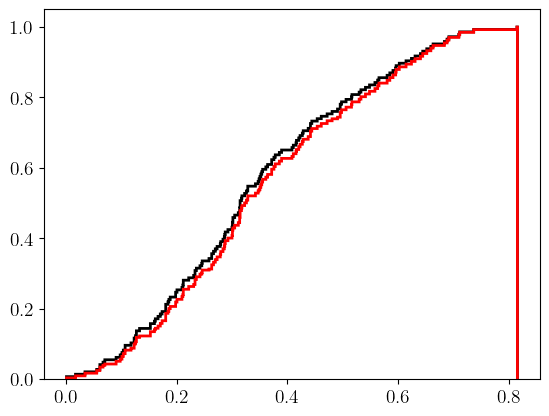

In [161]:
new_eccs = []
for i in range(len(orbit_solutions)):
    for _ in range(101-rates[i]):
        new_eccs.append(orbit_solutions[i]["eccentricity"])
    #tbins[0][np.minimum(inds[i]-1, 24)] += 100 - rates[i]

plt.hist(orbit_solutions["eccentricity"], bins=1000, histtype="step", cumulative=True, density=True, linewidth=2, color="k");
plt.hist(new_eccs, bins=1000, histtype="step", cumulative=True, density=True, linewidth=2, color="red");

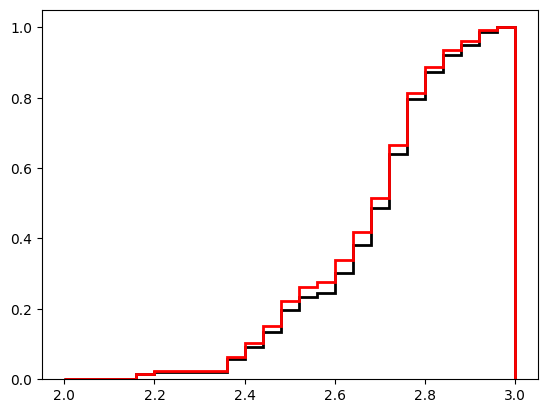

In [144]:
#period_mask = np.log10(orbit_solutions["period"]) < 3
#periods = np.log10(orbit_solutions["period"])[period_mask]
#tbins = np.histogram(periods, bins=25)
#inds = np.searchsorted(tbins[1], periods, side="right")
new_periods = []
for i in range(len(orbit_solutions)):
    for _ in range(101-rates[i]):
        new_periods.append(np.log10(orbit_solutions[i]["period"]))
    #tbins[0][np.minimum(inds[i]-1, 24)] += 100 - rates[i]

plt.hist(np.log10(orbit_solutions["period"]), bins=25, histtype="step", cumulative=True, density=True, linewidth=2, color="k", range=(2,3));
plt.hist(new_periods, bins=25, histtype="step", cumulative=True, density=True, linewidth=2, color="red", range=(2,3));
#cumulative_bins = np.cumsum(tbins[0])
#plt.plot(tbins[1][:-1]+(tbins[1][1:]-tbins[1][:-1])/2, cumulative_bins/np.max(cumulative_bins))

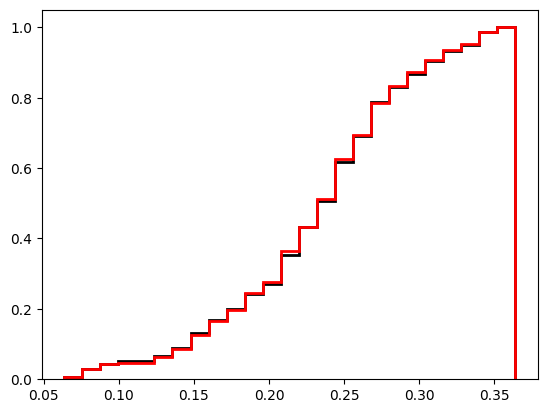

In [143]:
reasonable_mask = (orbit_solutions["m2"]/orbit_solutions["mass_single"]) < 1.0
masked_sols = orbit_solutions[reasonable_mask]
mass_ratios = (masked_sols["m2"]/masked_sols["mass_single"])

new_mass_ratios = []
for i in range(len(mass_ratios)):
    for _ in range(101-rates[i]):
        new_mass_ratios.append(mass_ratios[i])
    #tbins[0][np.minimum(inds[i]-1, 24)] += 100 - rates[i]

plt.hist(mass_ratios, bins=25, histtype="step", cumulative=True, density=True, linewidth=2, color="k");
plt.hist(new_mass_ratios, bins=25, histtype="step", cumulative=True, density=True, linewidth=2, color="red");

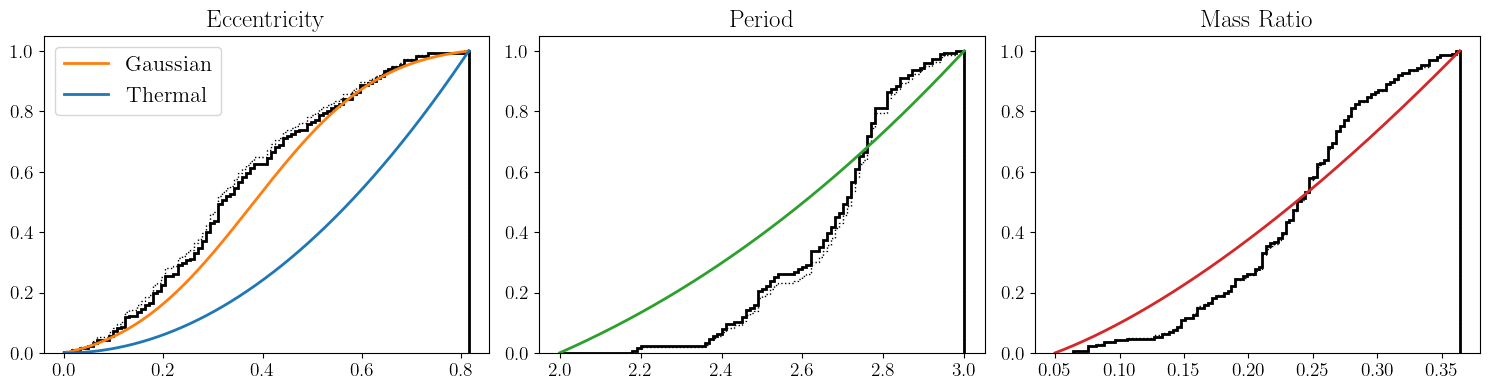

In [178]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Eccentricity
axes[0].hist(results["eccentricity"], bins=100, histtype="step", cumulative=True, density=True, linewidth=1, color="k", linestyle=":")
axes[0].hist(new_eccs, bins=100, histtype="step", cumulative=True, density=True, linewidth=2, color="k")
axes[0].plot(es, np.cumsum(pes) * (es[1] - es[0]), color="C1", linewidth=2, label="Gaussian");
axes[0].plot(es, np.cumsum(pts) * (es[1] - es[0]), color="C0", linewidth=2, label="Thermal");
axes[0].set_title("Eccentricity");
axes[0].legend();

# Period
axes[1].hist(np.log10(results["period"]), bins=100, histtype="step", cumulative=True, density=True, linewidth=1, color="k", range=(2,3), linestyle=":")
axes[1].hist(new_periods, bins=100, histtype="step", cumulative=True, density=True, linewidth=2, color="k", range=(2,3))
axes[1].plot(ps, np.cumsum(pps) * (ps[1] - ps[0]), color="C2", linewidth=2)
axes[1].set_title("Period")

# Mass Ratio
axes[2].hist(mass_ratios, bins=100, histtype="step", cumulative=True, density=True, linewidth=1, color="k", linestyle=":")
axes[2].hist(new_mass_ratios, bins=100, histtype="step", cumulative=True, density=True, linewidth=2, color="k")
axes[2].plot(qs, np.cumsum(qps) * (qs[1] - qs[0]), color="C3", linewidth=2)
axes[2].set_title("Mass Ratio")

plt.tight_layout()

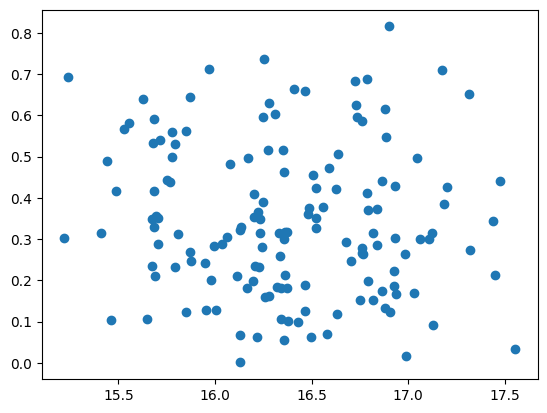

In [135]:
plt.scatter(orbit_solutions["phot_g_mean_mag"], orbit_solutions["eccentricity"]);

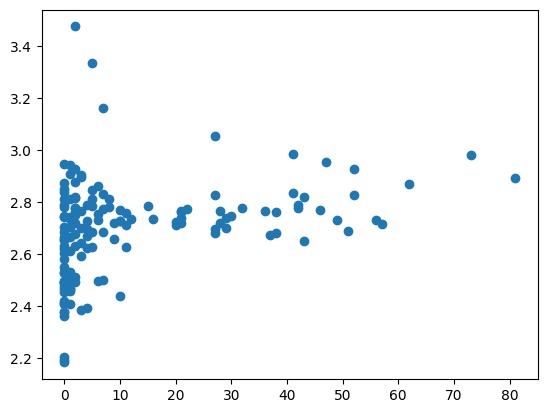

In [132]:
plt.scatter(rates, np.log10(orbit_solutions["period"]));